In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import os
import json

from tqdm import tqdm_notebook
from scipy.io import wavfile
from copy import deepcopy

In [2]:
#path_dataset = '../input/'
path_dataset = '/home/edoardobucheli/Datasets/FSDKaggle2018'

path_train = os.path.join(path_dataset,'audio_train_16k')
path_test = os.path.join(path_dataset,'audio_test_16k')

In [3]:
train_data = pd.read_csv(os.path.join(path_dataset,'train_post_competition.csv'))
test_data = pd.read_csv(os.path.join(path_dataset,'test_post_competition_scoring_clips.csv'))

In [4]:
train_data.head()

,fname,label,manually_verified,freesound_id,license
0,00044347.wav,Hi-hat,0,28739,Attribution
1,001ca53d.wav,Saxophone,1,358827,Attribution
2,002d256b.wav,Trumpet,0,10897,Creative Commons 0
3,0033e230.wav,Glockenspiel,1,325017,Attribution
4,00353774.wav,Cello,1,195688,Attribution


In [5]:
test_data.head()

,fname,label,usage,freesound_id,license
0,00326aa9.wav,Oboe,Private,355125,Attribution
1,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0
2,007759c4.wav,Saxophone,Private,13406,Creative Commons 0
3,008afd93.wav,Saxophone,Private,358962,Attribution
4,00ae03f6.wav,Chime,Private,78203,Attribution


In [6]:
classes = np.unique(train_data['label'])
n_classes = len(classes)

num_to_label = dict([[v,k] for v,k in enumerate(classes)])
label_to_num = dict([[k,v] for v,k in enumerate(classes)])

In [7]:
data_manual = train_data[train_data['manually_verified']==1]
data_auto = train_data[train_data['manually_verified']==0]

In [8]:
filenames_all = train_data['fname'].tolist()
labels_all = [label_to_num[f] for f in train_data['label']]

filenames_manual = data_manual['fname'].tolist()
labels_manual = [label_to_num[f] for f in data_manual['label']]

filenames_auto = data_auto['fname'].tolist()
labels_auto = [label_to_num[f] for f in data_auto['label']]

filenames_test = test_data['fname'].tolist()
labels_test = [label_to_num[f] for f in test_data['label']]

In [9]:
sr = 16000
length = 64000

### Load Test Data

In [10]:
x = np.zeros((1600,64000))

for i, file in enumerate(tqdm_notebook(filenames_test)):
    wave,_ = librosa.load(os.path.join(path_test,file),sr=sr,dtype = np.float32) 
    wave,_ = librosa.effects.trim(wave)
    
    if len(wave)<=length:

        amount = length-len(wave)
        wave = np.pad(wave,(int(np.ceil(amount/2)),int(np.floor(amount/2))),'constant')

    elif len(wave) > length:
        max_start = len(wave)-length
        
        start = np.random.randint(0,max_start)
        end = start + length
        
        wave = wave[start:end]
        
    wave = wave/np.max(np.absolute(wave+1e-10))
    x[i] = wave    

### Import Libraries for Models

In [13]:
import keras
import os 
import random
import numpy as np
import kapre

from keras.layers import Input
from keras.layers.convolutional import Conv1D
from keras.layers.core import Dense, Reshape, Permute
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.pooling import GlobalAveragePooling1D
from keras import metrics
from utils import util
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.core import Dropout 
from keras import backend as K
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D
from keras.layers import Add, Average, Concatenate, Multiply, Lambda, BatchNormalization, Activation, TimeDistributed
from keras import regularizers
from kapre.time_frequency import Melspectrogram, Spectrogram

Using TensorFlow backend.


In [14]:
def ccategorical_crossentropy(y_true, y_pred):
    
    y_true_v = K.greater(K.sum(y_true, axis=-1),1.1)
    y_true = y_true%1
    
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    loss = -K.sum(y_true*K.log(y_pred),axis=-1)

    m = K.max(loss)*0.8
    
    loss = loss 
    
    el = 1-(K.cast(K.greater(loss,m),'float32')*K.cast(y_true_v,'float32'))
    loss = loss*el
    return loss     

### Waveform Model 16k

In [15]:
model_filename = './COCAI_Models/dcase2018_task2_cochlearai_saved_models_16000_wav-1-fold_wav_model_1fold_0.8537611783271962.h5'

In [16]:
cocai_wf = keras.models.load_model(model_filename,
                                   custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram,
                                                   'Spectrogram':kapre.time_frequency.Spectrogram,
                                                   'ccategorical_crossentropy':ccategorical_crossentropy})

In [17]:
#for layer in cocai_wf_headless.layers:
    #print(layer.name)

In [18]:
new_output_name = 'reshape_16'
new_output_layer = cocai_wf.get_layer(new_output_name).output
cocai_wf_headless = keras.Model(inputs = cocai_wf.input, outputs = new_output_layer)

In [19]:
cocai_wf_headless.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1, None, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1, None, 1)   4           reshape_1[0][0]                  
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, None, 1)   4           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
concatenat

In [20]:
y_hat = cocai_wf_headless.predict(x)

In [21]:
y_hat = np.reshape(y_hat,(1600,512))

y_hat.shape

(1600, 512)

### Agglomerative Clusters

In [22]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [23]:
from collections import Counter

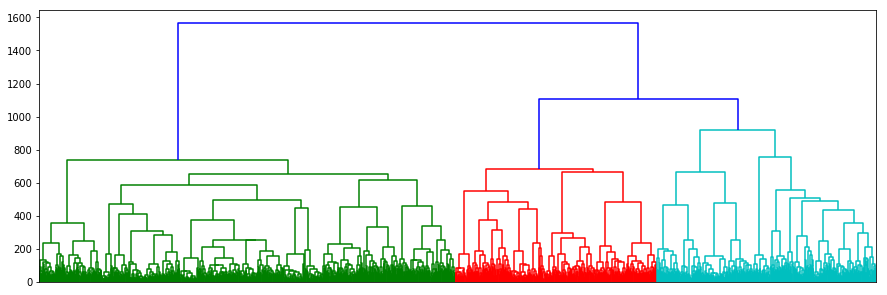

In [113]:
plt.figure(figsize = (15,5))
dendogram = sch.dendrogram(sch.linkage(y_hat, method = 'ward'))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [230]:
clusterer_1 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage = 'ward')
clusterer_1.fit(y_hat)
meta_labels = clusterer_1.labels_

In [231]:
meta_class1 = []
meta_class2 = []
meta_class3 = []
meta_class4 = []
meta_class5 = []
meta_class6 = []
meta_class7 = []


for i, this_ml in enumerate(meta_labels):
    if this_ml == 0:
        meta_class1.append(i)
    elif this_ml == 1:
        meta_class2.append(i)
    elif this_ml == 2:
        meta_class3.append(i)
    elif this_ml == 3:
        meta_class4.append(i)
    elif this_ml == 4:
        meta_class5.append(i)
    elif this_ml == 5:
        meta_class6.append(i)
    elif this_ml == 6:
        meta_class7.append(i)

In [232]:
mc_1_orig = [num_to_label[labels_test[f]] for f in meta_class1]
mc_2_orig = [num_to_label[labels_test[f]] for f in meta_class2]
mc_3_orig = [num_to_label[labels_test[f]] for f in meta_class3]
mc_4_orig = [num_to_label[labels_test[f]] for f in meta_class4]
mc_5_orig = [num_to_label[labels_test[f]] for f in meta_class5]
mc_6_orig = [num_to_label[labels_test[f]] for f in meta_class6]
mc_7_orig = [num_to_label[labels_test[f]] for f in meta_class7]

In [233]:
counts_mc1 = dict(Counter(mc_1_orig).most_common())
counts_mc2 = dict(Counter(mc_2_orig).most_common())
counts_mc3 = dict(Counter(mc_3_orig).most_common())
counts_mc4 = dict(Counter(mc_4_orig).most_common())
counts_mc5 = dict(Counter(mc_5_orig).most_common())
counts_mc6 = dict(Counter(mc_6_orig).most_common())
counts_mc7 = dict(Counter(mc_7_orig).most_common())

In [234]:
all_counts = [counts_mc1,counts_mc2,counts_mc3,counts_mc4,counts_mc5,counts_mc6,counts_mc7]

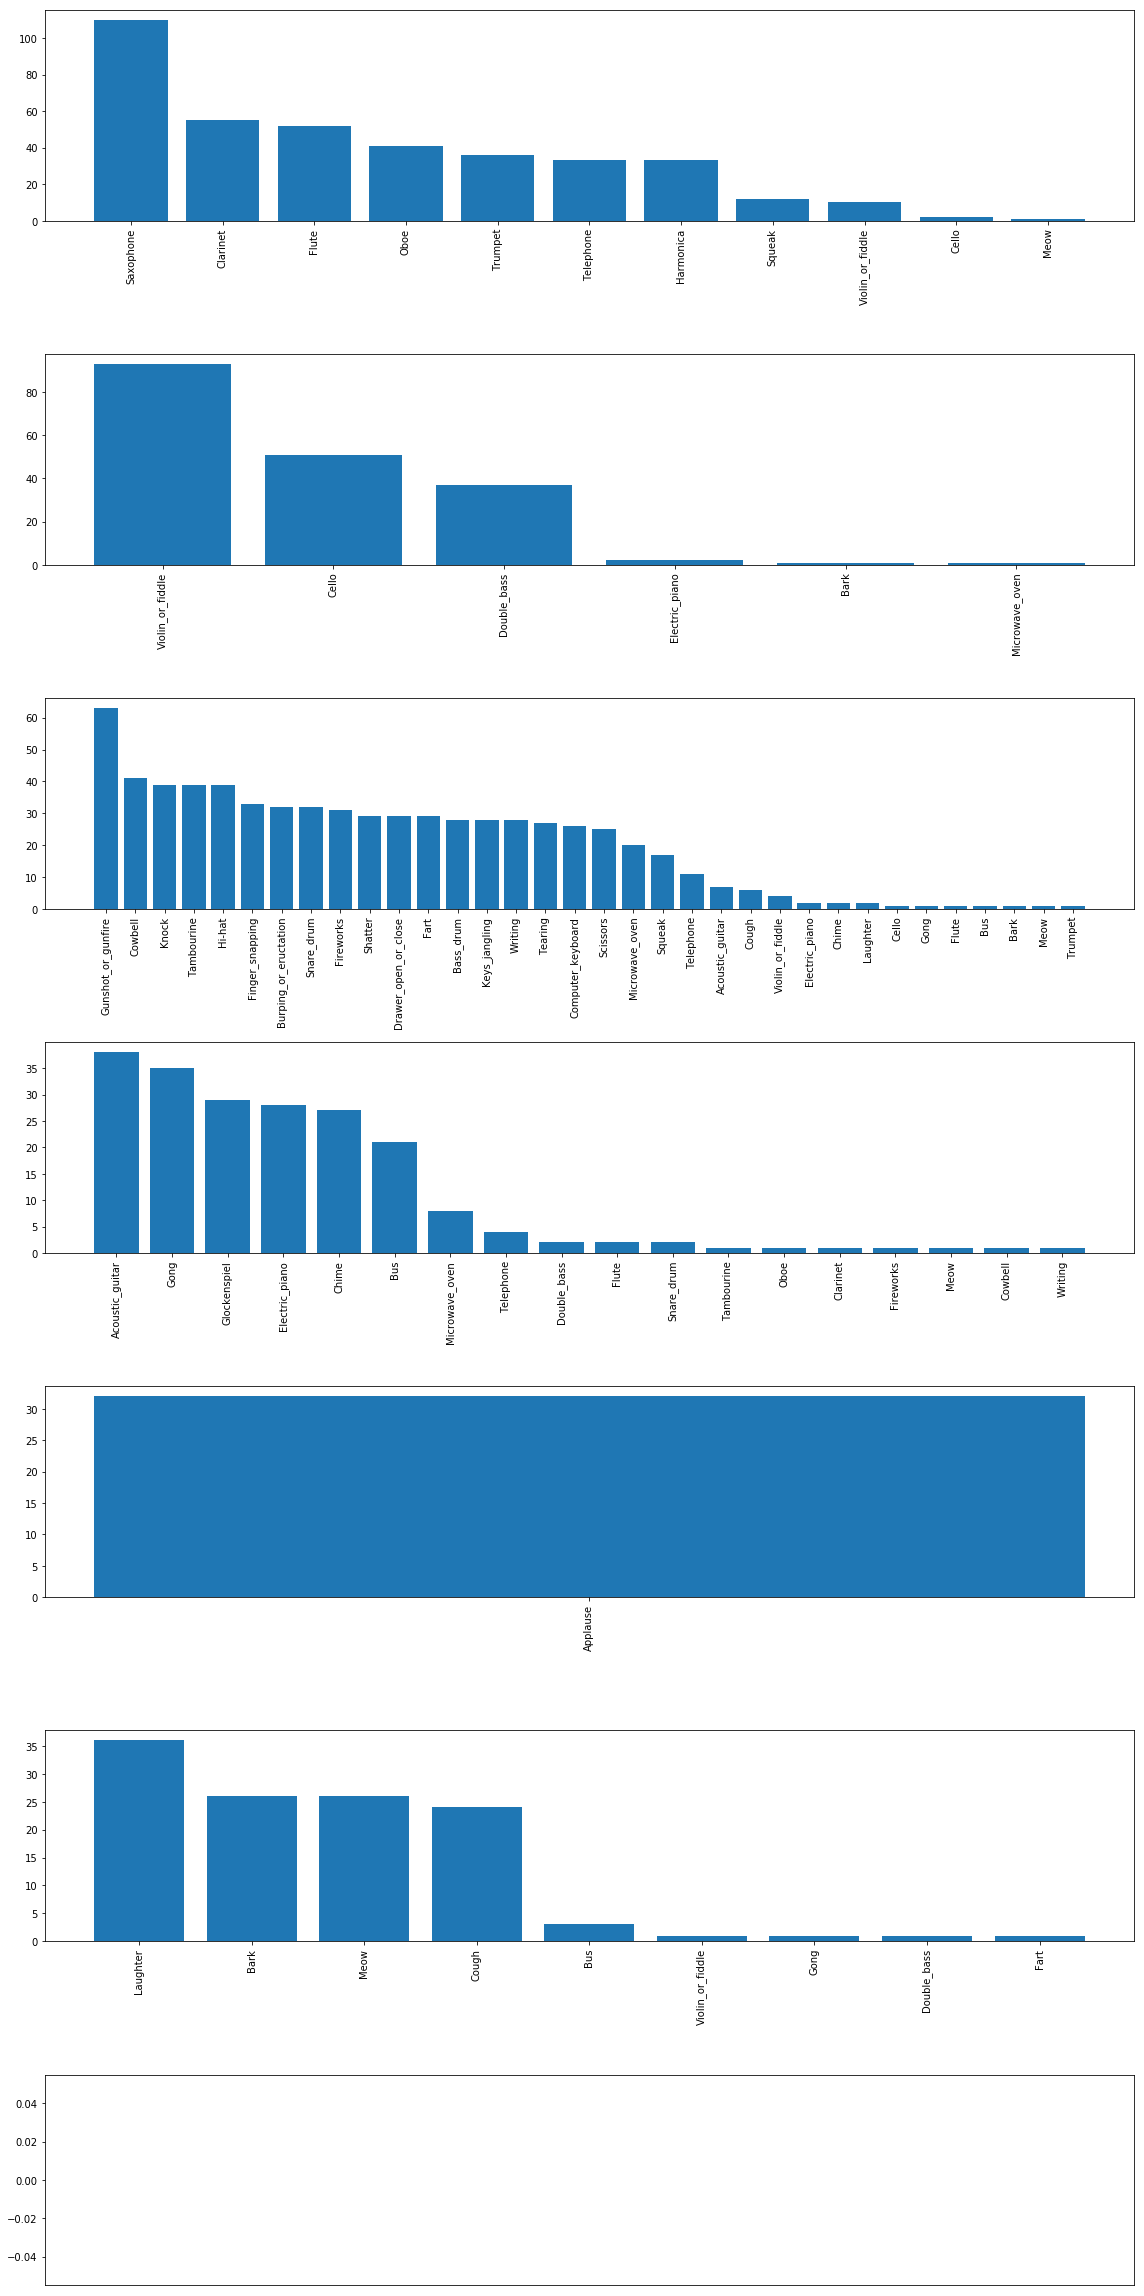

In [235]:
fig, axs = plt.subplots(7,1,figsize = (16,32))

for i,ax in enumerate(axs):
    
    length = len(all_counts[i])
    x_ticks = np.arange(length)
    values = all_counts[i].values()
    x_ticklabels = all_counts[i].keys()
    
    fig = ax.bar(x_ticks,values)
    fig = ax.set_xticks(x_ticks)
    fig = ax.set_xticklabels(x_ticklabels,rotation = 90)
plt.tight_layout()

In [240]:
classes_meta = dict([[f,[]] for f in classes])

In [241]:
for this_class in classes:
    if this_class in mc_1_orig:
        classes_meta[this_class].append(0)
    if this_class in mc_2_orig:
        classes_meta[this_class].append(1)
    if this_class in mc_3_orig:
        classes_meta[this_class].append(2)
    if this_class in mc_4_orig:
        classes_meta[this_class].append(3)
    if this_class in mc_5_orig:
        classes_meta[this_class].append(4)
    if this_class in mc_6_orig:
        classes_meta[this_class].append(5)
    if this_class in mc_7_orig:
        classes_meta[this_class].append(6)

In [242]:
classes_meta.items()

dict_items([('Acoustic_guitar', [2, 3]), ('Applause', [4]), ('Bark', [1, 2, 5]), ('Bass_drum', [2]), ('Burping_or_eructation', [2]), ('Bus', [2, 3, 5]), ('Cello', [0, 1, 2]), ('Chime', [2, 3]), ('Clarinet', [0, 3]), ('Computer_keyboard', [2]), ('Cough', [2, 5]), ('Cowbell', [2, 3]), ('Double_bass', [1, 3, 5]), ('Drawer_open_or_close', [2]), ('Electric_piano', [1, 2, 3]), ('Fart', [2, 5]), ('Finger_snapping', [2]), ('Fireworks', [2, 3]), ('Flute', [0, 2, 3]), ('Glockenspiel', [3]), ('Gong', [2, 3, 5]), ('Gunshot_or_gunfire', [2]), ('Harmonica', [0]), ('Hi-hat', [2]), ('Keys_jangling', [2]), ('Knock', [2]), ('Laughter', [2, 5]), ('Meow', [0, 2, 3, 5]), ('Microwave_oven', [1, 2, 3]), ('Oboe', [0, 3]), ('Saxophone', [0]), ('Scissors', [2]), ('Shatter', [2]), ('Snare_drum', [2, 3]), ('Squeak', [0, 2]), ('Tambourine', [2, 3]), ('Tearing', [2]), ('Telephone', [0, 2, 3]), ('Trumpet', [0, 2]), ('Violin_or_fiddle', [0, 1, 2, 5]), ('Writing', [2, 3])])

In [243]:
label_to_meta = dict([[k,1000] for k in classes])

In [244]:
for my_class, clusters in classes_meta.items():
    
    print(my_class)
    print('Present in {}'.format(clusters))
    if len(clusters) > 1:
        
        times_in_cluster = []
        for i in clusters:
            times_in_cluster.append(all_counts[i][my_class])
            print('\tCluster: {}\n\tCounts: {}'.format(i,all_counts[i][my_class]))
            
        this_max = np.argmax(times_in_cluster)
        print('\tWinner: {}\n\n'.format(clusters[this_max]))
        label_to_meta[my_class] = clusters[this_max]
        
    elif len(clusters) == 1:
        print('\tOnly one class')
        print('\tWinner: {}\n\n'.format(clusters))
        
        label_to_meta[my_class] = clusters[0]
        
    elif len(clusters) < 1:
        print('whaaaaaa?')

Acoustic_guitar
Present in [2, 3]
	Cluster: 2
	Counts: 7
	Cluster: 3
	Counts: 38
	Winner: 3


Applause
Present in [4]
	Only one class
	Winner: [4]


Bark
Present in [1, 2, 5]
	Cluster: 1
	Counts: 1
	Cluster: 2
	Counts: 1
	Cluster: 5
	Counts: 26
	Winner: 5


Bass_drum
Present in [2]
	Only one class
	Winner: [2]


Burping_or_eructation
Present in [2]
	Only one class
	Winner: [2]


Bus
Present in [2, 3, 5]
	Cluster: 2
	Counts: 1
	Cluster: 3
	Counts: 21
	Cluster: 5
	Counts: 3
	Winner: 3


Cello
Present in [0, 1, 2]
	Cluster: 0
	Counts: 2
	Cluster: 1
	Counts: 51
	Cluster: 2
	Counts: 1
	Winner: 1


Chime
Present in [2, 3]
	Cluster: 2
	Counts: 2
	Cluster: 3
	Counts: 27
	Winner: 3


Clarinet
Present in [0, 3]
	Cluster: 0
	Counts: 55
	Cluster: 3
	Counts: 1
	Winner: 0


Computer_keyboard
Present in [2]
	Only one class
	Winner: [2]


Cough
Present in [2, 5]
	Cluster: 2
	Counts: 6
	Cluster: 5
	Counts: 24
	Winner: 5


Cowbell
Present in [2, 3]
	Cluster: 2
	Counts: 41
	Cluster: 3
	Counts: 1
	Winner:

In [245]:
label_to_meta

{'Acoustic_guitar': 3,
 'Applause': 4,
 'Bark': 5,
 'Bass_drum': 2,
 'Burping_or_eructation': 2,
 'Bus': 3,
 'Cello': 1,
 'Chime': 3,
 'Clarinet': 0,
 'Computer_keyboard': 2,
 'Cough': 5,
 'Cowbell': 2,
 'Double_bass': 1,
 'Drawer_open_or_close': 2,
 'Electric_piano': 3,
 'Fart': 2,
 'Finger_snapping': 2,
 'Fireworks': 2,
 'Flute': 0,
 'Glockenspiel': 3,
 'Gong': 3,
 'Gunshot_or_gunfire': 2,
 'Harmonica': 0,
 'Hi-hat': 2,
 'Keys_jangling': 2,
 'Knock': 2,
 'Laughter': 5,
 'Meow': 5,
 'Microwave_oven': 2,
 'Oboe': 0,
 'Saxophone': 0,
 'Scissors': 2,
 'Shatter': 2,
 'Snare_drum': 2,
 'Squeak': 2,
 'Tambourine': 2,
 'Tearing': 2,
 'Telephone': 0,
 'Trumpet': 0,
 'Violin_or_fiddle': 1,
 'Writing': 2}

In [251]:
with open('./label_to_meta_v1.json','w') as fp:
    json.dump(label_to_meta,fp)

In [246]:
m1 = []
m2 = []
m3 = []
m4 = []
m5 = []
m6 = []
m7 = []

for label, meta in label_to_meta.items():
    if meta == 0:
        m1.append(label)
    elif meta == 1:
        m2.append(label)
    elif meta == 2:
        m3.append(label)
    elif meta == 3:
        m4.append(label)
    elif meta == 4:
        m5.append(label)
    elif meta == 5:
        m6.append(label)
    elif meta == 6:
        m7.append(label)
    else:
        print('askjdna')
    

In [247]:
print(m1,'\n')
print(m2,'\n')
print(m3,'\n')
print(m4,'\n')
print(m5,'\n')
print(m6,'\n')

['Clarinet', 'Flute', 'Harmonica', 'Oboe', 'Saxophone', 'Telephone', 'Trumpet'] 

['Cello', 'Double_bass', 'Violin_or_fiddle'] 

['Bass_drum', 'Burping_or_eructation', 'Computer_keyboard', 'Cowbell', 'Drawer_open_or_close', 'Fart', 'Finger_snapping', 'Fireworks', 'Gunshot_or_gunfire', 'Hi-hat', 'Keys_jangling', 'Knock', 'Microwave_oven', 'Scissors', 'Shatter', 'Snare_drum', 'Squeak', 'Tambourine', 'Tearing', 'Writing'] 

['Acoustic_guitar', 'Bus', 'Chime', 'Electric_piano', 'Glockenspiel', 'Gong'] 

['Applause'] 

['Bark', 'Cough', 'Laughter', 'Meow'] 



### Mel Model 16k

In [34]:
model2_filename = './COCAI_Models/dcase2018_task2_cochlearai_saved_models_16000_mel-1-fold_mel_model_1fold_0.8858495528669121.h5'

In [35]:
cocai_mel = keras.models.load_model(model2_filename,
                                    custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram,
                                                    'Spectrogram':kapre.time_frequency.Spectrogram,
                                                    'ccategorical_crossentropy':ccategorical_crossentropy})

In [36]:
#for layer in cocai_mel.layers:
    #print(layer.name)

In [39]:
new_output_name2 = 'reshape_10'
new_output_layer2 = cocai_mel.get_layer(new_output_name2).output
cocai_mel_headless = keras.Model(inputs = cocai_mel.input, outputs = new_output_layer2)

In [40]:
cocai_mel_headless.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, None, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 1)      4           reshape_1[0][0]                  
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, None)      0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
trainable_

In [41]:
y_hat2 = cocai_mel_headless.predict(x)

In [42]:
y_hat2 = np.reshape(y_hat2,(1600,512))

### Agglomerative Clusters

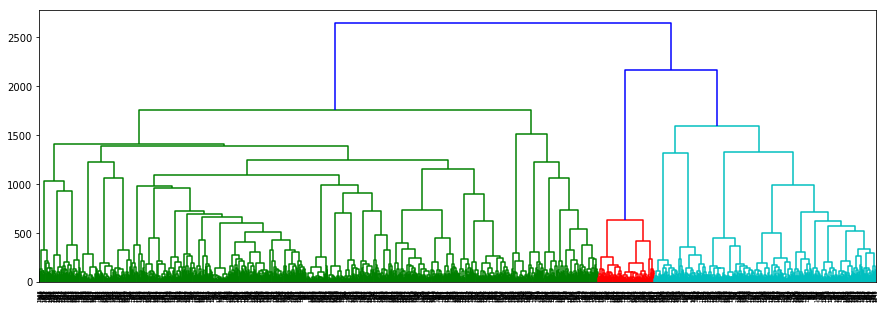

In [43]:
plt.figure(figsize = (15,5))
dendogram = sch.dendrogram(sch.linkage(y_hat2, method = 'ward'))

In [44]:
cluster_model2 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage = 'ward')
cluster_model2.fit(y_hat2)
meta_labels = cluster_model2.labels_

In [45]:
meta_class1 = []
meta_class2 = []
meta_class3 = []
meta_class4 = []
meta_class5 = []
meta_class6 = []


for i, this_ml in enumerate(meta_labels):
    if this_ml == 0:
        meta_class1.append(i)
    elif this_ml == 1:
        meta_class2.append(i)
    elif this_ml == 2:
        meta_class3.append(i)
    elif this_ml == 3:
        meta_class4.append(i)
    elif this_ml == 4:
        meta_class5.append(i)
    elif this_ml == 5:
        meta_class6.append(i)

In [46]:
mc_1_orig = [num_to_label[labels_test[f]] for f in meta_class1]
mc_2_orig = [num_to_label[labels_test[f]] for f in meta_class2]
mc_3_orig = [num_to_label[labels_test[f]] for f in meta_class3]
mc_4_orig = [num_to_label[labels_test[f]] for f in meta_class4]
mc_5_orig = [num_to_label[labels_test[f]] for f in meta_class5]
mc_6_orig = [num_to_label[labels_test[f]] for f in meta_class6]

In [47]:
counts_mc1 = dict(Counter(mc_1_orig).most_common())
counts_mc2 = dict(Counter(mc_2_orig).most_common())
counts_mc3 = dict(Counter(mc_3_orig).most_common())
counts_mc4 = dict(Counter(mc_4_orig).most_common())
counts_mc5 = dict(Counter(mc_5_orig).most_common())
counts_mc6 = dict(Counter(mc_6_orig).most_common())

In [48]:
all_counts = [counts_mc1,counts_mc2,counts_mc3,counts_mc4,counts_mc5,counts_mc6]

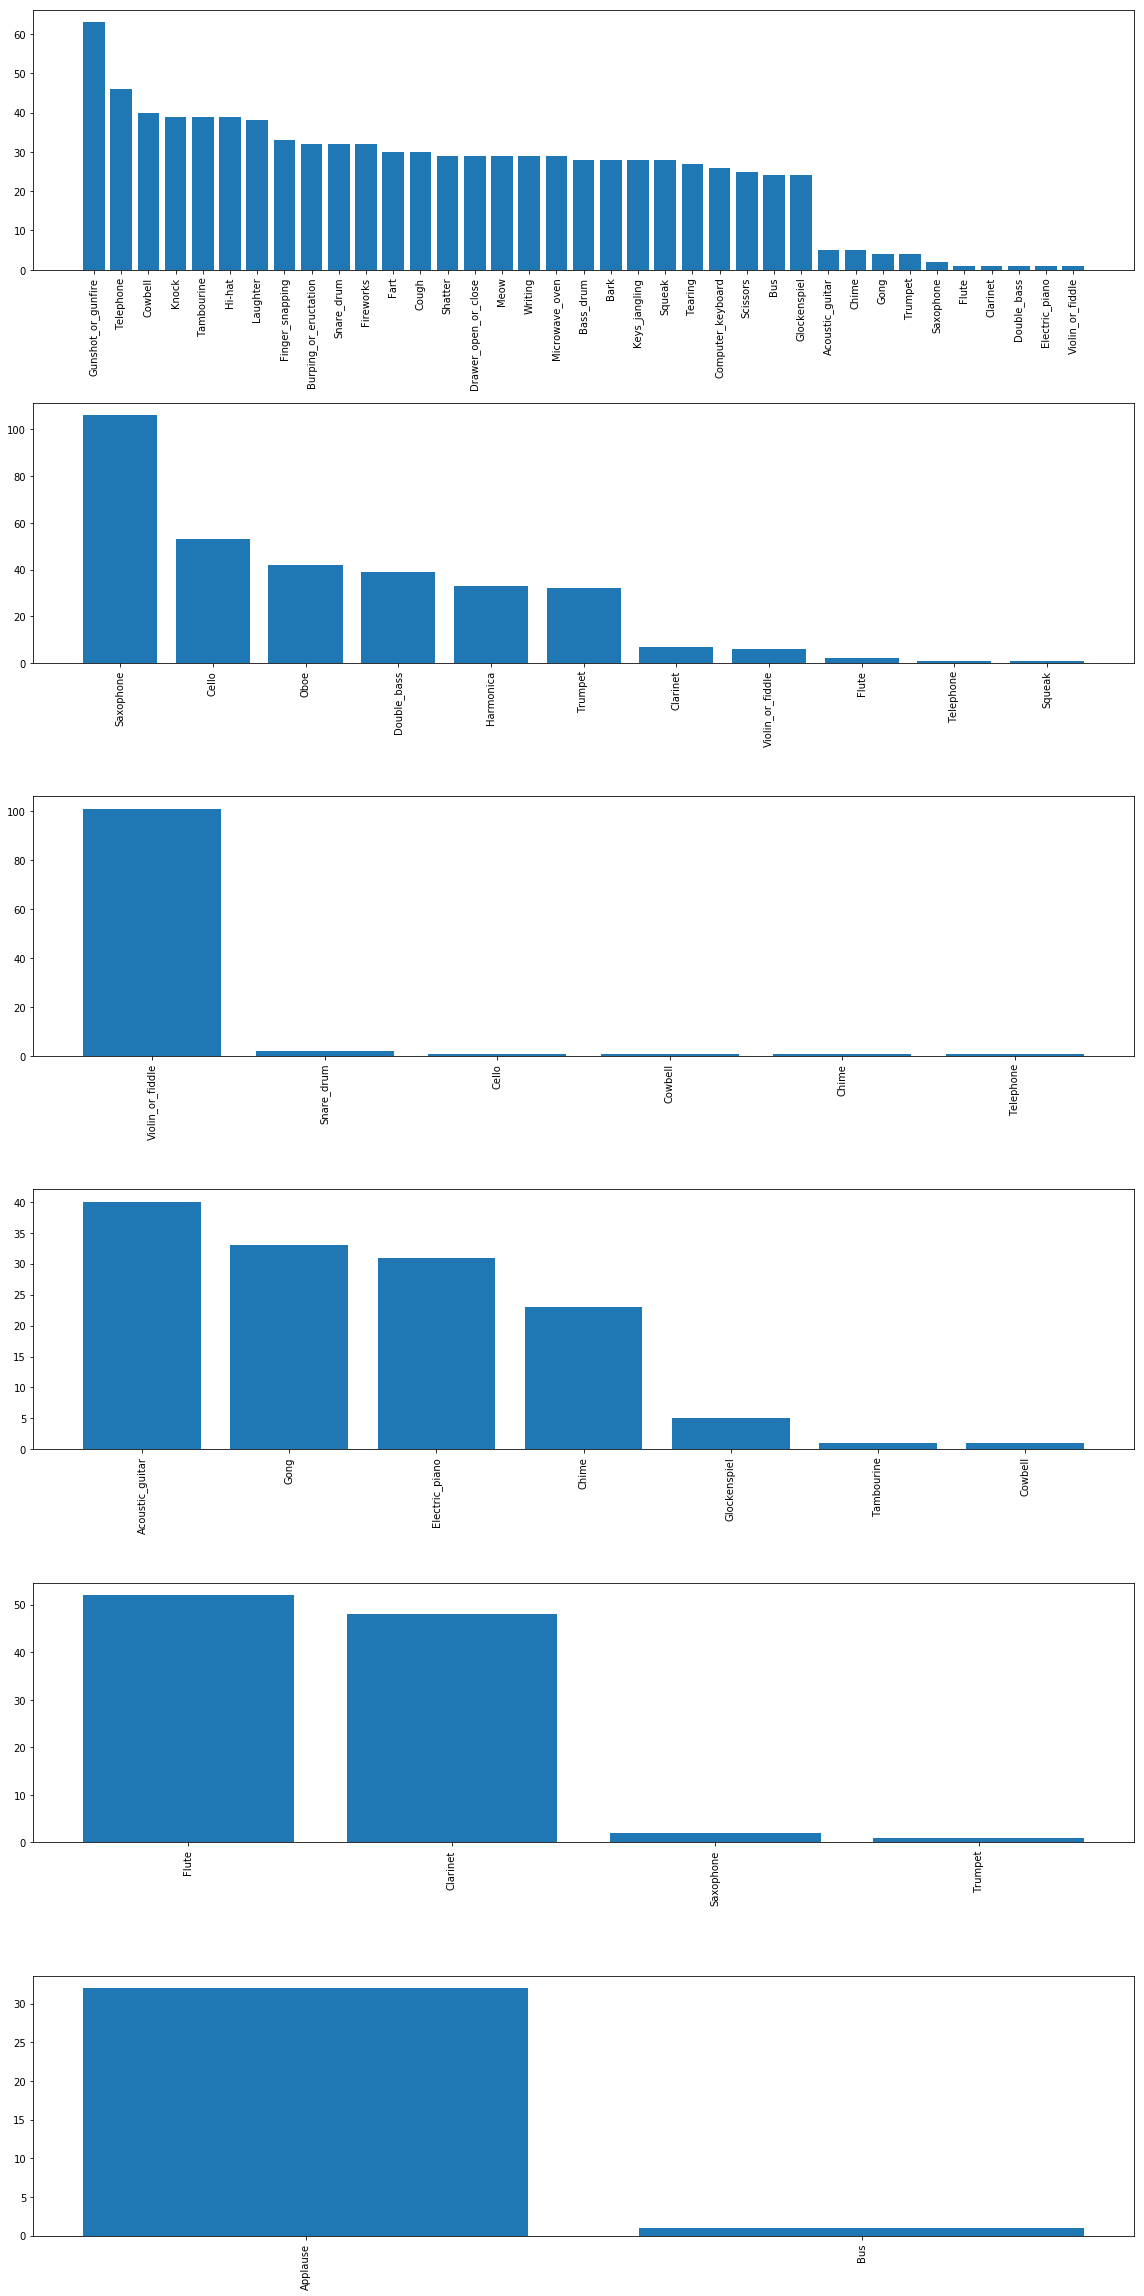

In [49]:
fig, axs = plt.subplots(6,1,figsize = (16,32))

for i,ax in enumerate(axs):
    
    length = len(all_counts[i])
    x_ticks = np.arange(length)
    values = all_counts[i].values()
    x_ticklabels = all_counts[i].keys()
    
    fig = ax.bar(x_ticks,values)
    fig = ax.set_xticks(x_ticks)
    fig = ax.set_xticklabels(x_ticklabels,rotation = 90)
plt.tight_layout()

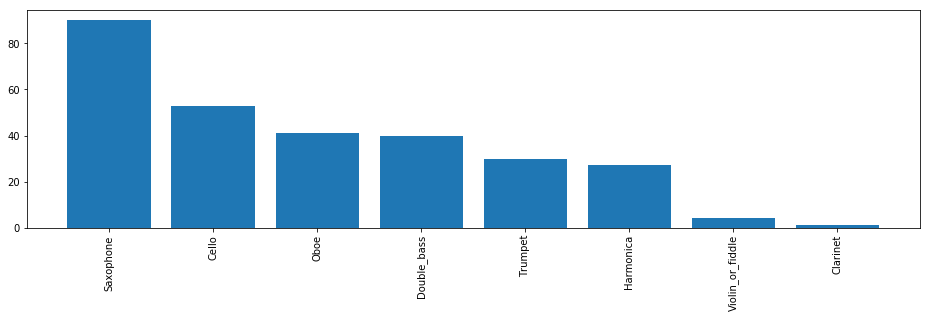

In [163]:
fig, ax = plt.subplots(1,1,figsize = (16,4))

fig = ax.bar(np.arange(len(counts_mc1)),counts_mc1.values())
fig = ax.set_xticks(np.arange(len(counts_mc1)))
fig = ax.set_xticklabels(counts_mc1.keys(),rotation = 90)

### Cluster from MS-40

In [50]:
import pickle

In [51]:
with open('./preprocessed_test/MS-80-HL512-WF16k-64k','rb') as fp:
    data = pickle.load(fp)

In [52]:
x_mels = np.zeros((1600,80,126))

for i, spect in enumerate(data):
    
    if spect.shape[1] > 126:
        max_start = spect.shape[1]-126
        start = np.random.randint(0,max_start)
        end = start+126
        spect = spect[:,start:end]
    elif spect.shape[1] == 126:
        pass
    elif spect.shape[1] < 126:
        print("Hol\'up a minute'")
        print("Problem at  {}".format(i))
        
    x_mels[i] = spect

In [54]:
x_mels2 = np.reshape(x_mels,(1600,10080,))

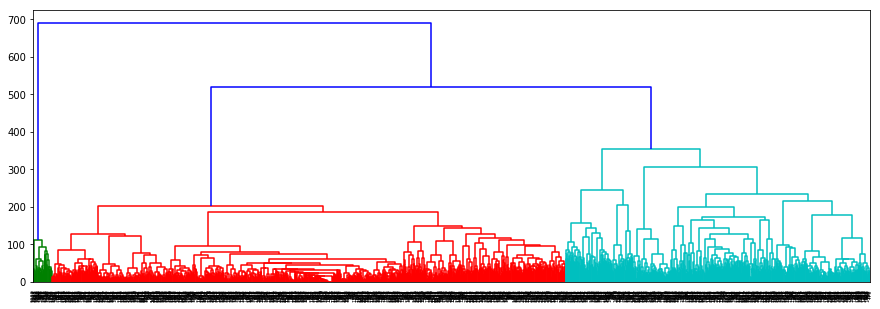

In [55]:
plt.figure(figsize = (15,5))
dendogram = sch.dendrogram(sch.linkage(x_mels2, method = 'ward'))

In [56]:
cluster_model3 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage = 'ward')
cluster_model3.fit(x_mels2)
meta_labels = cluster_model3.labels_

In [57]:
meta_class1 = []
meta_class2 = []
meta_class3 = []
meta_class4 = []
meta_class5 = []
meta_class6 = []


for i, this_ml in enumerate(meta_labels):
    if this_ml == 0:
        meta_class1.append(i)
    elif this_ml == 1:
        meta_class2.append(i)
    elif this_ml == 2:
        meta_class3.append(i)
    elif this_ml == 3:
        meta_class4.append(i)
    elif this_ml == 4:
        meta_class5.append(i)
    elif this_ml == 5:
        meta_class6.append(i)

In [58]:
mc_1_orig = [num_to_label[labels_test[f]] for f in meta_class1]
mc_2_orig = [num_to_label[labels_test[f]] for f in meta_class2]
mc_3_orig = [num_to_label[labels_test[f]] for f in meta_class3]
mc_4_orig = [num_to_label[labels_test[f]] for f in meta_class4]
mc_5_orig = [num_to_label[labels_test[f]] for f in meta_class5]
mc_6_orig = [num_to_label[labels_test[f]] for f in meta_class6]

In [59]:
counts_mc1 = dict(Counter(mc_1_orig).most_common())
counts_mc2 = dict(Counter(mc_2_orig).most_common())
counts_mc3 = dict(Counter(mc_3_orig).most_common())
counts_mc4 = dict(Counter(mc_4_orig).most_common())
counts_mc5 = dict(Counter(mc_5_orig).most_common())
counts_mc6 = dict(Counter(mc_6_orig).most_common())

In [60]:
all_counts = [counts_mc1,counts_mc2,counts_mc3,counts_mc4,counts_mc5,counts_mc6]

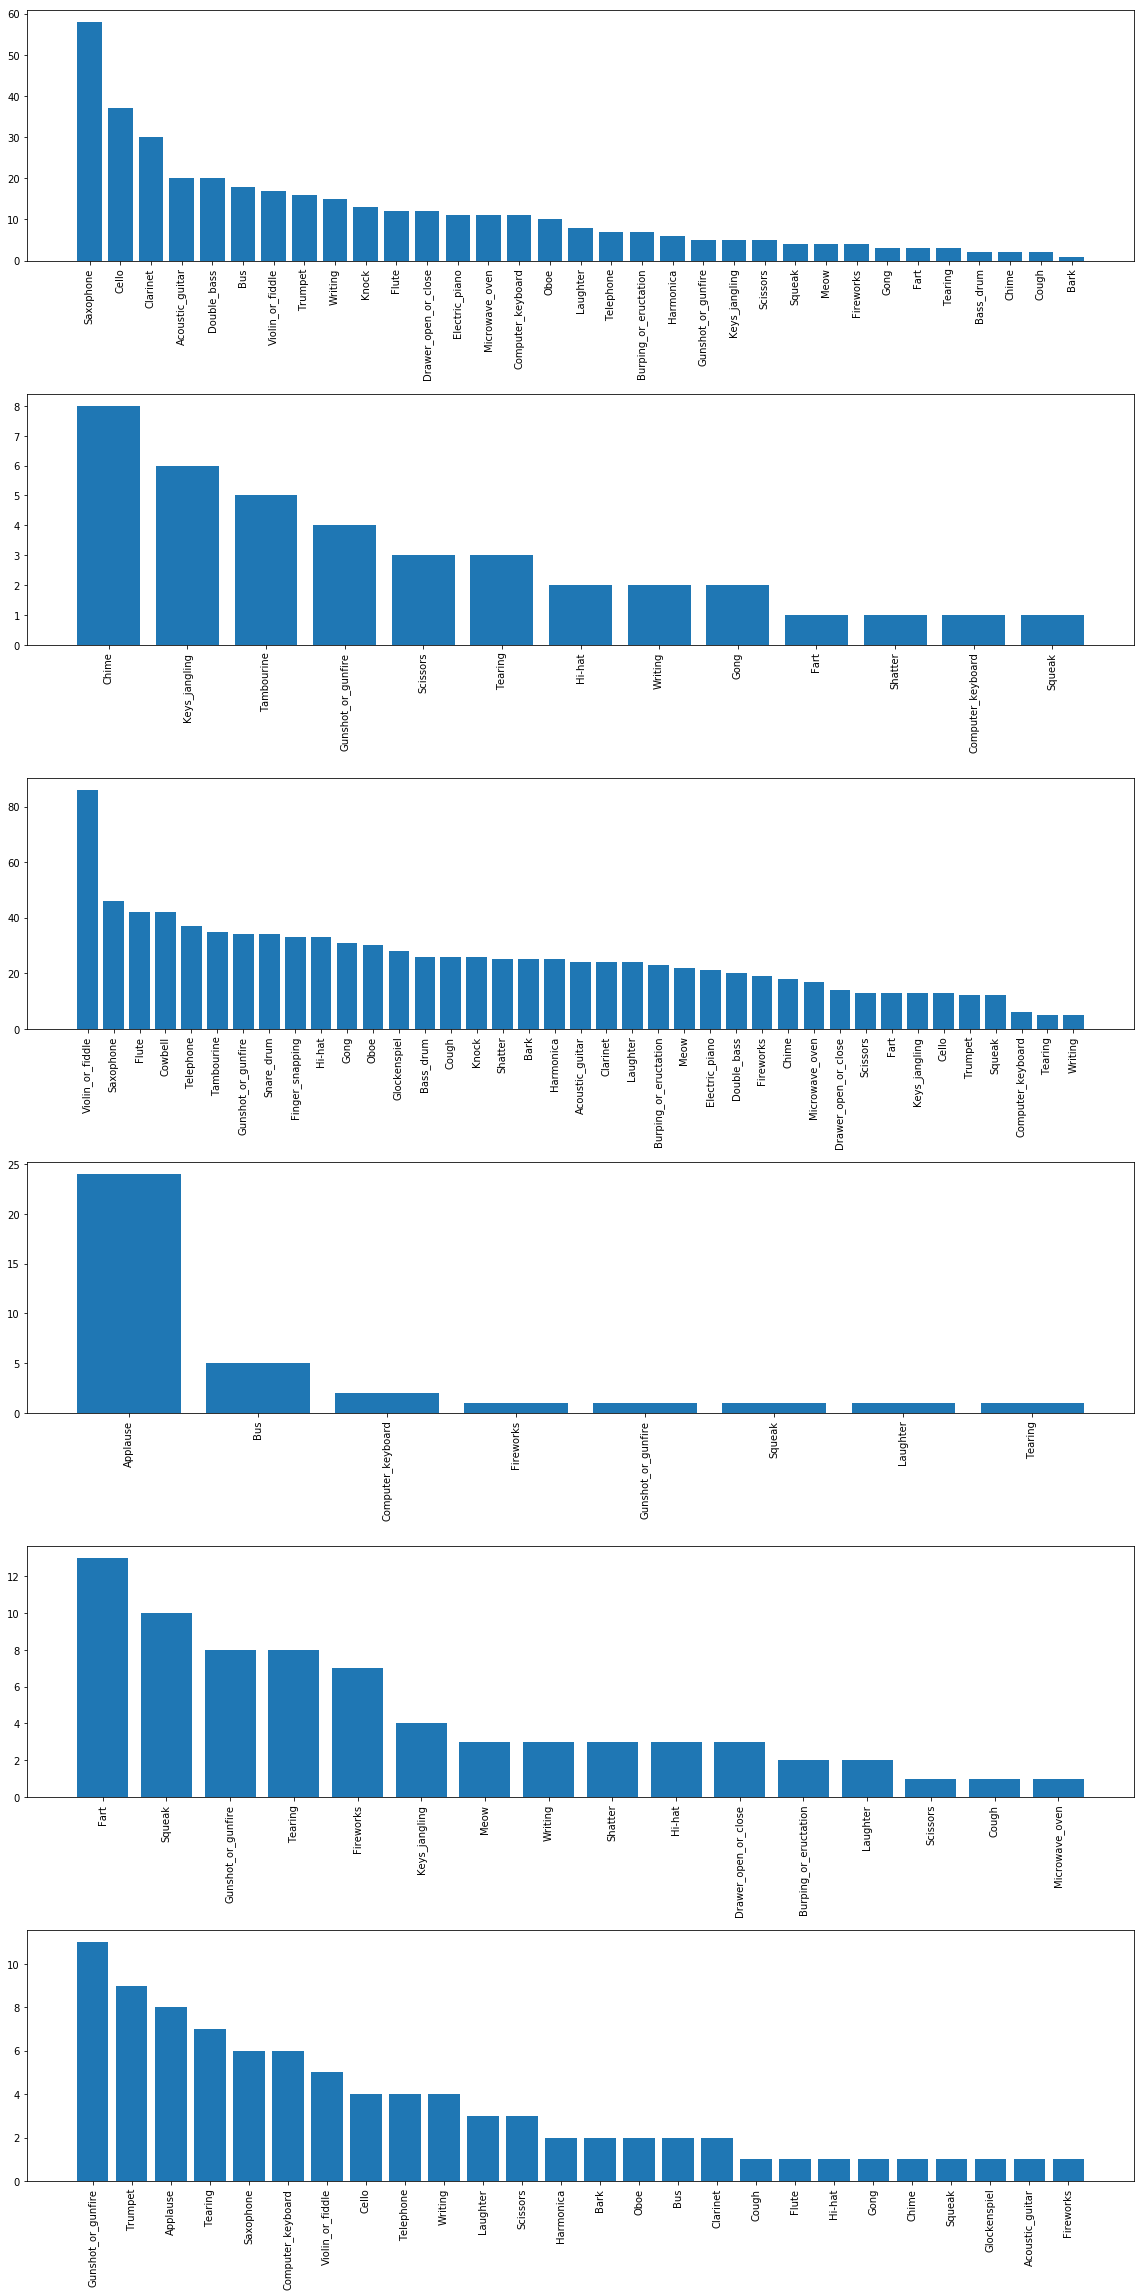

In [61]:
fig, axs = plt.subplots(6,1,figsize = (16,32))

for i,ax in enumerate(axs):
    
    length = len(all_counts[i])
    x_ticks = np.arange(length)
    values = all_counts[i].values()
    x_ticklabels = all_counts[i].keys()
    
    fig = ax.bar(x_ticks,values)
    fig = ax.set_xticks(x_ticks)
    fig = ax.set_xticklabels(x_ticklabels,rotation = 90)
plt.tight_layout()